In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import pandas_ta as ta
import re
import requests
import yfinance as yf

from datetime import datetime, timedelta

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import notebook_utils

In [2]:
products = {
    "crypto": [
        "BTC-USD",
        "ETH-USD",
        "SOL-USD",
        "XRP-USD",
        "DOT-USD",
    ],
    # "stock": ["GBTC", "TQQQ"],
    # "stock": ["GBTC", "TQQQ", "SQQQ"],
    # "stock": ["TQQQ", "SQQQ"],
    # "stock": ["UPRO", "SPXU"],
}


# def get_top_stocks(url):
#     top_stocks = []

#     with requests.Session() as req:
#         req.headers.update(
#             {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0"}
#         )

#         for ticker in ["QQQ", "VUG", "VGT"]:
#             r = req.get(url.format(ticker))
#             print(f"Extracting: {r.url}")
#             holdings = re.findall(r"etf\\\/(.*?)\\", r.text)
#             top_holdings = holdings[:30]

#             if len(top_stocks) == 0:
#                 top_stocks = top_holdings
#             else:
#                 top_stocks = list(set(top_stocks).intersection(top_holdings))

#     return top_stocks


# top_stocks = get_top_stocks("https://www.zacks.com/funds/etf/{}/holding")
# print(top_stocks)
# products["stock"] = top_stocks

In [3]:
def get_df_crypto_fear_greed_index():
    print("Retrieving historical crypto fear and greed index")
    fear_greed_index_response = requests.get("https://api.alternative.me/fng/?limit=" + str(24 * 365 * 5))
    df_fear_greed_index = pd.DataFrame(fear_greed_index_response.json()["data"])
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(int(x), unit="s", tz="UTC") for x in df_fear_greed_index.timestamp]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"value": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_etf_fear_greed_index():
    print("Retrieving historical ETF fear and greed index")
    import json

    with open("cnn_fear_greed_index_data.json") as f:
        cnn_fear_greed_index_data = json.load(f)

    df_fear_greed_index = pd.DataFrame(
        data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
    )
    df_fear_greed_index.set_index(
        pd.DatetimeIndex([pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]),
        inplace=True,
    )
    df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
    return df_fear_greed_index


def get_df_history(product_id, product_type):
    print(f"Retrieving historical data for {product_id}")

    df_history = yf.Ticker(product_id).history(interval="1d", period="5y")[:-1]
    df_history.columns = map(str.lower, df_history.columns)

    timestamps = [pd.to_datetime(x, utc=True).round(freq="D") for x in df_history.index.values]
    timestamps_date_range = pd.date_range(start=timestamps[0], end=timestamps[-1], freq="D")
    df_history = df_history.set_index(pd.DatetimeIndex(timestamps)).reindex(timestamps_date_range, method="ffill")

    df_fear_greed_index = df_crypto_fear_greed_index if product_type == "crypto" else df_etf_fear_greed_index
    df_history = df_history.join(df_fear_greed_index[["fear_greed_index"]], how="inner")
    df_history["fear_greed_index"] = df_history.fear_greed_index.fillna(method="ffill").astype(float)

    def get_strategy_length(x):
        return x * 1

    for column in ["close", "fear_greed_index"]:
        # for days in [7, 14, 30, 60, 90, 120]:
        for days in [14]:
            periods = get_strategy_length(days)
            # df_history[f"{column}_previous"] = df_history[column].shift(1)
            df_history[f"{column}_min_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).min()
            df_history[f"{column}_max_{days}"] = df_history[column].rolling(window=periods, min_periods=periods).max()
            # df_history[f"{column}_gradient_{days}"] = df_history[column].diff(periods=periods) / periods
            # df_history[f"{column}_gradient_min_{days}"] = (
            #     df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).min()
            # )
            # df_history[f"{column}_gradient_max_{days}"] = (
            #     df_history[f"{column}_gradient_{days}"].rolling(window=periods, min_periods=periods).max()
            # )

    CustomStrategy = ta.Strategy(
        name="Momo and Volatility",
        ta=[
            # {"kind": "sma", "length": get_strategy_length(10)},
            # {"kind": "sma", "length": get_strategy_length(20)},
            # {"kind": "sma", "length": get_strategy_length(50)},
            # {"kind": "bbands", "length": get_strategy_length(20)},
            {"kind": "rsi", "length": get_strategy_length(14)},
            # {
            #     "kind": "macd",
            #     "fast": get_strategy_length(8),
            #     "slow": get_strategy_length(21),
            # },
            # {
            #     "kind": "sma",
            #     "close": "volume",
            #     "length": get_strategy_length(10),
            #     "prefix": "VOLUME",
            # },
            # {
            #     "kind": "sma",
            #     "close": "volume",
            #     "length": get_strategy_length(20),
            #     "prefix": "VOLUME",
            # },
            # {
            #     "kind": "sma",
            #     "close": "volume",
            #     "length": get_strategy_length(50),
            #     "prefix": "VOLUME",
            # },
        ],
    )
    df_history.ta.strategy(CustomStrategy)

    return df_history


df_crypto_fear_greed_index = get_df_crypto_fear_greed_index()
df_etf_fear_greed_index = get_df_etf_fear_greed_index()

history_dfs = {}
product_ids = []

for product_type in products.keys():
    for product_id in products[product_type]:
        product_ids.append(product_id)
        history_dfs[product_id] = get_df_history(product_id, product_type=product_type)
        history_dfs[product_id]["product_id"] = product_id
        history_dfs[product_id]["product_type"] = product_type

df_final = pd.concat([history_dfs[product_id] for product_id in product_ids]).sort_index()

for product_id in product_ids:
    df_final_product = df_final.loc[df_final.product_id == product_id]
    # df_final = df_final.loc[(df_final.index >= df_final_product.index.min()) & (df_final.index <= df_final_product.index.max())]
    # df_final = df_final.loc[df_final.index.isin(df_final_product.index)]

df_final

Retrieving historical crypto fear and greed index
Retrieving historical ETF fear and greed index
Retrieving historical data for BTC-USD
Retrieving historical data for ETH-USD
Retrieving historical data for SOL-USD
Retrieving historical data for XRP-USD
Retrieving historical data for DOT-USD


,open,high,low,close,volume,dividends,stock splits,fear_greed_index,close_min_14,close_max_14,fear_greed_index_min_14,fear_greed_index_max_14,RSI_14,product_id,product_type
2019-02-05 00:00:00+00:00,3454.950928,3478.148193,3451.937012,3466.357422,5227549545,0.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,BTC-USD,crypto
2019-02-05 00:00:00+00:00,0.299763,0.301278,0.297210,0.299239,424722760,0.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,XRP-USD,crypto
2019-02-05 00:00:00+00:00,107.628166,108.134789,106.909897,107.443520,2515863999,0.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,ETH-USD,crypto
2019-02-06 00:00:00+00:00,3469.091797,3469.091797,3398.565430,3413.767822,5482196038,0.0,0.0,14.0,NaN,NaN,NaN,NaN,NaN,BTC-USD,crypto
2019-02-06 00:00:00+00:00,0.299430,0.299491,0.290419,0.290727,456205130,0.0,0.0,14.0,NaN,NaN,NaN,NaN,NaN,XRP-USD,crypto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-03 00:00:00+00:00,43184.964844,43359.941406,42890.808594,42992.250000,11169245236,0.0,0.0,60.0,39507.367188,43288.246094,48.0,63.0,53.508453,BTC-USD,crypto
2024-02-03 00:00:00+00:00,0.510398,0.525740,0.506031,0.518939,861729960,0.0,0.0,60.0,0.503193,0.546111,48.0,63.0,40.707969,XRP-USD,crypto
2024-02-03 00:00:00+00:00,2307.980225,2327.346924,2293.538086,2296.038330,4647754021,0.0,0.0,60.0,2217.710205,2453.913086,48.0,63.0,46.386526,ETH-USD,crypto
2024-02-03 00:00:00+00:00,100.451134,101.058983,96.812576,97.879982,1349320819,0.0,0.0,60.0,83.622810,101.566666,48.0,63.0,53.278859,SOL-USD,crypto


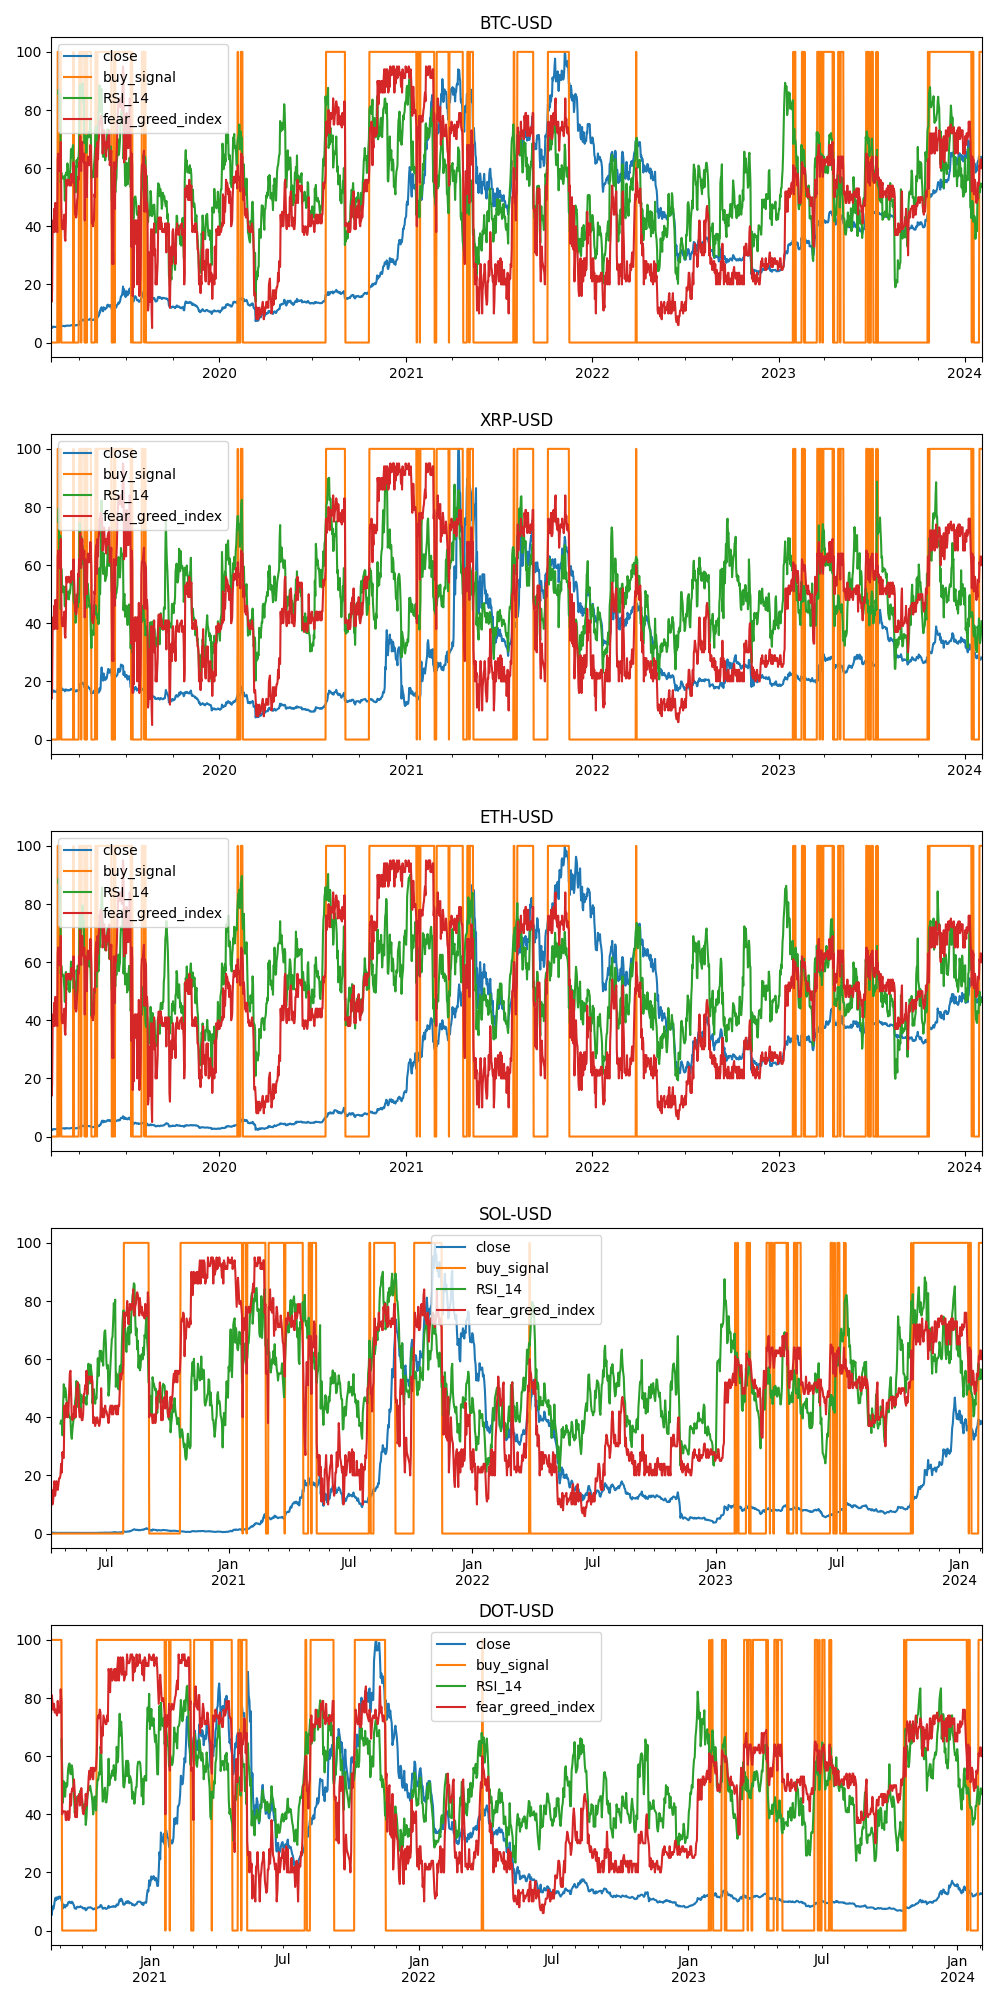

In [4]:
total_products = df_final.product_id.nunique()
fig, ax = plt.subplots(nrows=total_products, figsize=(10, 4 * total_products))
days = 14

for product_index, product_id in enumerate(df_final.product_id.unique()):
    ax_index = ax if total_products <= 1 else ax[product_index]
    df_final_product = df_final.loc[df_final.product_id == product_id]
    df_history1 = df_final_product[["close"]].copy()
    # df_history2 = df_final_product[[f"close_gradient_{days}", f"close_gradient_min_{days}", f"close_gradient_max_{days}"]].copy()
    df_history3 = df_final_product[
        [f"RSI_{days}", "fear_greed_index", f"fear_greed_index_max_{days}", f"fear_greed_index_min_{days}"]
    ].copy()
    # df_history4 = df_final_product[[f"fear_greed_index_gradient_{days}", f"fear_greed_index_gradient_min_{days}", f"fear_greed_index_gradient_max_{days}"]].copy()
    # df_history5 = df_final_product[["BBP_20_2.0"]].copy()

    df_history1_max = df_history1.to_numpy()[~np.isnan(df_history1.to_numpy())].max()
    # df_history2_max = df_history2.to_numpy()[~np.isnan(df_history2.to_numpy())].max()
    df_history3_max = df_history3.to_numpy()[~np.isnan(df_history3.to_numpy())].max()
    # df_history4_max = df_history4.to_numpy()[~np.isnan(df_history4.to_numpy())].max()
    # df_history5_max = df_history5.to_numpy()[~np.isnan(df_history5.to_numpy())].max()

    for column in df_history1.columns:
        df_history1[column] = df_history1[column] / df_history1_max * 100

    df_history = (
        df_history1
        # .join(df_history2, how="outer")
        .join(df_history3, how="outer")
        # .join(df_history4, how="outer")
        # .join(df_history5, how="outer")
    )
    # df_history = history_dfs[product_id]
    # row.RSI_14 >= row.fear_greed_index_max_14 or (row.RSI_14 >= 50 and row.fear_greed_index >= 50)
    df_history["buy_signal"] = (
        (df_history["fear_greed_index"] >= 60)
        # (df_history[f"RSI_{days}"] >= df_history[f"fear_greed_index_max_14"])
        # | ((df_history[f"RSI_{days}"] >= 50) & (df_history[f"fear_greed_index_min_14"] >= 60))
        # # (df_history[f"RSI_{days}"] >= (100 - df_history[f"fear_greed_index_max_{days}"]))
        # # ((df_history[f"RSI_{days}"] >= 50) & ((100 - df_history["fear_greed_index_min_14"]) >= 60))
    ).replace({True: 100, False: 0})

    df_history[
        [
            "close",
            "buy_signal",
            f"RSI_{days}",
            "fear_greed_index",
            # f"fear_greed_index_max_{days}",
            # f"fear_greed_index_min_{days}",
        ]
    ].plot(ax=ax_index)

    ax_index.set_title(product_id)

plt.legend()
plt.tight_layout()
plt.show()

Total fee percentage: 0%
Start money: $1000
Min buy amount: $10
Max buy amount: $100
End money: $32920.77
Pct earned: 3192.077%
Total orders: 2371
Avg pct earned per order: 1.346%
Total volume: $419884.86
Total days: 1824.0
Avg 30 day volume: $6906.00


,product_id,side,amount,products,value,money,total_balance
timestamp,,,,,,,
2019-02-18 00:00:00+00:00,BTC-USD,buy,100.0,0.02553812431704534,3915.71435546875,900.0,1000.0
2019-02-18 00:00:00+00:00,XRP-USD,buy,100.0,310.9762047044902,0.32156801223754883,800.0,1000.0
2019-02-18 00:00:00+00:00,ETH-USD,buy,100.0,0.684470317251616,146.09837341308594,700.0,1000.0
2019-02-19 00:00:00+00:00,BTC-USD,buy,100.0,0.025335091532605415,3947.094482421875,600.0,1000.9706840221465
2019-02-19 00:00:00+00:00,XRP-USD,buy,100.0,308.86314622687667,0.3237679898738861,500.0,1000.9706840221465
...,...,...,...,...,...,...,...
2024-02-03 00:00:00+00:00,BTC-USD,buy,100.0,0.0023260006163901632,42992.25,30817.29909802042,32920.770891829365
2024-02-03 00:00:00+00:00,XRP-USD,buy,100.0,192.70086943417863,0.5189390182495117,30717.29909802042,32920.770891829365
2024-02-03 00:00:00+00:00,ETH-USD,buy,100.0,0.04355327987777861,2296.038330078125,30617.29909802042,32920.770891829365


,product_id,side,total_orders
0,BTC-USD,buy,490
1,BTC-USD,sell,59
2,ETH-USD,buy,481
3,ETH-USD,sell,59
4,SOL-USD,buy,381
5,SOL-USD,sell,34
6,XRP-USD,buy,434
7,XRP-USD,sell,72
8,DOT-USD,buy,328
9,DOT-USD,sell,33


<Axes: xlabel='timestamp'>

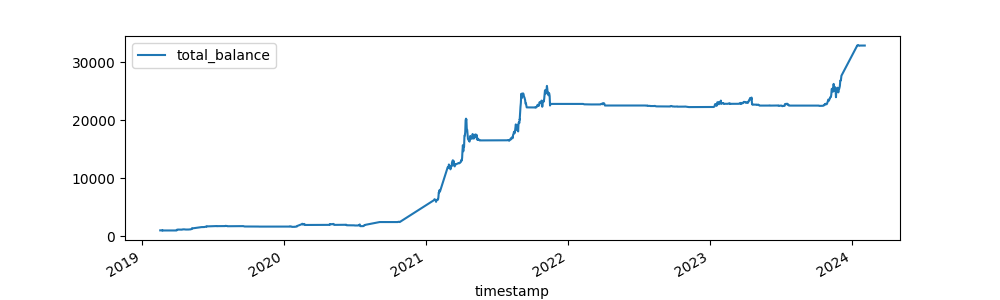

In [5]:
fee_pct = 0
p_keep = 1 - (fee_pct / 2 / 100)
print(f"Total fee percentage: {fee_pct}%")

purchased_products = {}
total_products = len(product_ids)

for product_id in product_ids:
    purchased_products[product_id] = 0

money = 1000
start_money = money
print(f"Start money: ${start_money}")

min_buy_amount = 10
max_buy_amount = 100
print(f"Min buy amount: ${min_buy_amount}")
print(f"Max buy amount: ${max_buy_amount}")

total_orders = 0
total_volume = 0
orders = []


def get_total_balance():
    total_balance = money

    for product_product_id in product_ids:
        df_final_product_period = df_final.loc[(df_final.index == index) & (df_final.product_id == product_product_id)]

        if len(df_final_product_period) > 0:
            total_balance += purchased_products[product_product_id] * df_final_product_period.close.values[-1] * p_keep

    return total_balance


def floor_value(x: float, precision: int):
    return np.true_divide(np.floor(x * 10**precision), 10**precision)


def buy_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        # buy_amount = floor_value(money / total_products / 10, 2)
        # buy_amount = floor_value(money / len(products[product_data["product_type"]]) / 10, 2)
        buy_amount = floor_value(money / len(products[product_data["product_type"]]), 2)
        buy_amount = buy_amount if buy_amount >= min_buy_amount else min_buy_amount
        buy_amount = buy_amount if buy_amount <= max_buy_amount else max_buy_amount

        if money >= buy_amount and buy_amount > 0:
            money -= buy_amount
            buy_products = buy_amount / product_data["close"] * p_keep
            purchased_products[product_id] += buy_products
            total_orders += 1
            total_volume += buy_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "buy",
                    "amount": buy_amount,
                    "products": buy_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


def sell_product(product_id):
    global money
    global orders
    global purchased_products
    global total_orders
    global total_volume

    product_data = df_final.loc[(df_final.index == index) & (df_final.product_id == product_id)].to_dict("records")

    if len(product_data) > 0:
        product_data = product_data[0]

        sell_products = floor_value(purchased_products[product_id], 8)
        sell_amount = sell_products * product_data["close"] * p_keep

        if sell_amount > 0:
            purchased_products[product_id] -= sell_products
            total_orders += 1
            total_volume += sell_amount
            money += sell_amount
            orders.append(
                {
                    "timestamp": index,
                    "product_id": product_id,
                    "side": "sell",
                    "amount": sell_amount,
                    "products": sell_products,
                    "value": product_data["close"],
                    "money": money,
                    "total_balance": get_total_balance(),
                }
            )


for index, row in df_final.iterrows():
    if row.product_type == "crypto" and (row.RSI_14 >= 60 or row.fear_greed_index >= 60):
        buy_product(row.product_id)
    elif row.product_type == "stock" and (
        (
            row.product_id in ["GBTC", "SPXL", "UPRO", "TQQQ"]
            and (row.RSI_14 >= row.fear_greed_index_max_14 or (row.RSI_14 >= 50 and row.fear_greed_index_min_14 >= 60))
        )
        # (row.product_id in ["SPXS", "SPXU", "SQQQ"] and (
        #     row.RSI_14 >= (100 - row.fear_greed_index_max_14)
        #     or (row.RSI_14 >= 50 and (100 - row.fear_greed_index_max_14) >= 60)
        # ))
    ):
        buy_product(row.product_id)
    else:
        sell_product(row.product_id)

money += sum(
    [
        (purchased_products[product_id] * df_final.loc[df_final.product_id == product_id].close.values[-1] * p_keep)
        for product_id in product_ids
    ]
)

print(f"End money: ${money:.2f}")
pct_earned = (money - start_money) / start_money * 100
print(f"Pct earned: {pct_earned:.3f}%")
days = (df_final.index.values[-1] - df_final.index.values[0]).astype("timedelta64[D]") / np.timedelta64(1, "D")
print(f"Total orders: {total_orders}")
print(f"Avg pct earned per order: {pct_earned / total_orders:.3f}%")
print(f"Total volume: ${total_volume:.2f}")
print(f"Total days: {days}")
print(f"Avg 30 day volume: ${(total_volume / days * 30):.2f}")

df_orders = pd.DataFrame(orders)
df_orders.set_index("timestamp", inplace=True)
display(df_orders.astype(str))

orders_info = []
for product_id in product_ids:
    for side in ["buy", "sell"]:
        df_orders_product_side = df_orders.loc[(df_orders.product_id == product_id) & (df_orders.side == side)]
        orders_info.append({"product_id": product_id, "side": side, "total_orders": len(df_orders_product_side)})

df_orders_info = pd.DataFrame(orders_info)
display(df_orders_info)

df_orders[["total_balance"]].plot(figsize=(10, 3))

In [6]:
# display(df_orders.loc[df_orders.side == "buy"].describe())
# display(df_orders.loc[df_orders.side == "sell"].describe())

In [7]:
# df_final.loc[df_final.product_id == "VGT"][:100][["product_type", "close", "fear_greed_index", "fear_greed_index_max_14", "RSI_14"]]